## EEG Classification
in this project we have Rest EEG from a person and goinig to remove blink artifacts

### Loading the libs




In [1]:
%matplotlib inline
# %pylab osx
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import keras
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv1D, MaxPooling1D,UpSampling1D,Reshape
import os
import pickle
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, TimeDistributed, Bidirectional, Input,LSTM,GRU
from keras.utils.test_utils import keras_test
# Some additional libraries which we'll use just
# to produce some visualizations of our training

import IPython.display as ipyd
plt.style.use('ggplot')

Using TensorFlow backend.


### data structure

In [2]:
import scipy.io as spio

sampleRate=500
samples=85
M=3
data1=np.zeros((M,samples,sampleRate))
for k in range(1,M+1):
    path='F%d.mat'%k
    mat=spio.loadmat(path,squeeze_me=True)
    F1=mat['Fz'][:samples*sampleRate]
    for i in range (samples):
        data1[k-1,i]=F1[i*sampleRate:(i+1)*sampleRate]
        

In [3]:
path='Final_Train.mat'
mat=spio.loadmat(path,squeeze_me=True)
x_data=mat['Final_Train']

path='Final_Train_grndth.mat'
mat2=spio.loadmat(path,squeeze_me=True)
y_data=mat2['Final_Train_grndth']


path='Final_Test.mat'
mat=spio.loadmat(path,squeeze_me=True)
x_data1=mat['Final_Test']
print(x_data.shape)
path='Final_Test_grndth.mat'
mat2=spio.loadmat(path,squeeze_me=True)
y_data1=mat2['Final_Test_grndth']


x_data2=np.zeros((x_data.shape[0]+x_data1.shape[0],x_data.shape[1]))
x_data2[:x_data.shape[0]]=x_data
x_data2[x_data.shape[0]:x_data.shape[0]+x_data1.shape[0]]=x_data1
x_data=x_data2
x_data=x_data.reshape((x_data.shape[0],x_data.shape[1],1)).astype('float32')

y_data2=np.zeros((y_data.shape[0]+y_data1.shape[0],y_data.shape[1]))
y_data2[:y_data.shape[0]]=y_data
y_data2[y_data.shape[0]:y_data.shape[0]+y_data1.shape[0]]=y_data1
y_data=y_data2
y_data=y_data.reshape((y_data.shape[0],y_data.shape[1],1)).astype('float32')

minx=np.min(x_data)
miny=np.min(y_data)

x_data=x_data-minx
y_data=y_data-miny
maxx=np.max(x_data)
maxy=np.max(y_data)
x_data=(np.divide(x_data,maxx))#/np.max(x_data,axis=0)
y_data=(np.divide(y_data,maxy))#/np.max(x_data,axis=0)


print(x_data.shape)
print(y_data.shape)

(2730, 500)
(2801, 500, 1)
(2801, 500, 1)


# reshape input to be [samples, time steps, features]
x_data = np.reshape(x_data, (x_data.shape[0], 1, x_data.shape[1]))
#y_data = np.reshape(y_data, (y_data.shape[0], 1, y_data.shape[1]))

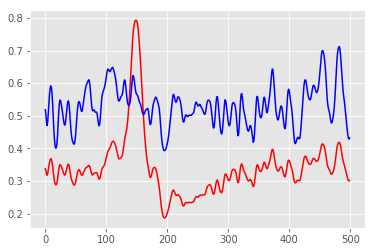

In [4]:
plt.plot(x_data[1],'r')
plt.plot(y_data[1],'b')

In [5]:
# Split the data into train, val, and test sets. In addition we will
# create a small development set as a subset of the training data;
# we can use this for development so our code runs faster.

datasize=x_data.shape[0]
num_training = datasize-71
num_test = 71

x=np.arange(num_training)
np.random.shuffle(x)


X_test = x_data[num_training:num_training + num_test]
y_test = y_data[num_training:num_training + num_test]

# Our training set will be the first num_train points from the original
# training set.
mask = x[:num_training]
X_train = x_data[mask]
y_train = y_data[mask]



print ('Train data shape: ', X_train.shape)
print ('Train labels shape: ', y_train.shape)
print ('Test data shape: ', X_test.shape)
print ('Test labels shape: ', y_test.shape)

Train data shape:  (2730, 500, 1)
Train labels shape:  (2730, 500, 1)
Test data shape:  (71, 500, 1)
Test labels shape:  (71, 500, 1)


In [6]:

save_dir = os.path.join(os.getcwd(), 'saved_models')
model_name = 'M6S2.h5'



In [7]:
from keras import backend as K
from keras.layers import Input
input_sig=Input(shape=(500,1))

x = Dense(100, activation='relu')(input_sig) 
#x = UpSampling1D(2)(x)
x = Dense(100, activation='relu')(x)
#x = UpSampling1D(2)(x)
#x = Conv1D(64, 5, activation='relu', border_mode='same')(x)
encoded =(x)

print ("shape of encoded", K.int_shape(encoded))

shape of encoded (None, 500, 100)


In [8]:
from keras.layers import Cropping1D
x = Dense(200, activation='relu')(encoded)
#x = MaxPooling1D(2, border_mode='same')(x)
x = Dense(100, activation='relu')(x)
#x = MaxPooling1D(2, border_mode='same')(x)
 
x = Dense(1, activation='relu')(x) 

#x = MaxPooling1D(2, border_mode='same')(x)
#x=Cropping1D(cropping=(2, 2))(x)
decoded =(x)
print ("shape of decoded", K.int_shape(decoded))

autoencoder = Model(input_sig, decoded)
# initiate RMSprop optimizer
opt = keras.optimizers.rmsprop(lr=0.0001, decay=1e-6)

# Let's train the model using RMSprop
autoencoder.compile(loss='mse',
              optimizer=opt)

shape of decoded (None, 500, 1)


In [9]:
path='saved_models/M6S2.h5'
#autoencoder.load_weights(path)


autoencoder.fit(X_train, y_train,validation_split=0.1, epochs=100, batch_size=100,
                verbose=1)

In [10]:
# Save model and weights
if not os.path.isdir(save_dir):
    os.makedirs(save_dir)
model_path = os.path.join(save_dir, model_name)
autoencoder.save(model_path)
print('Saved trained model at %s ' % model_path)





Saved trained model at /home/pardis1/Mreza/EEG_Remove_Artifacts_RNN/saved_models/M6S2.h5 


In [11]:
def distance2(p0,p1):
    
    return ((p0[0] - p1[0])**2 + (p0[1] - p1[1])**2)

def distance(p0,p1):
    
    return ((p0 - p1)**2)

RMSE Estmation=85.457377


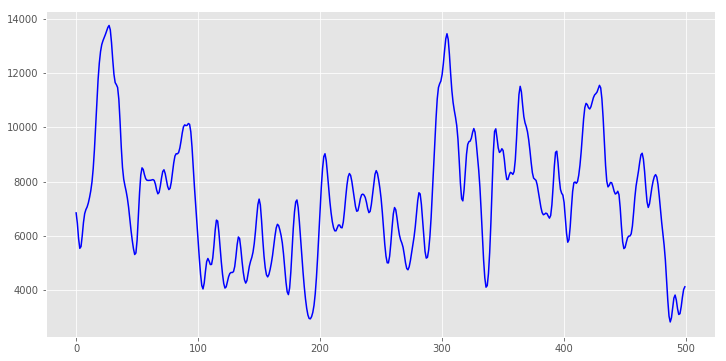

In [12]:
y_valid_predicted_lstm=autoencoder.predict(X_test)
#y_predic=y_valid_predicted_lstm*np.max(y_data2,axis=0)+np.min(y_data,axis=0)
y_predic=np.multiply(y_valid_predicted_lstm,maxy)+miny
y_test=np.multiply(y_test,maxy)+miny
rms=np.zeros((y_test.shape[0],y_test.shape[1]))

for i in range(y_test.shape[0]):
    
    for m in range(y_test.shape[1]):
    
    
        rms[i,m] = (distance(y_test[i,m], y_predic[i,m]))

    
rmsM=np.sqrt(np.mean(np.mean(rms,axis=1)))


print('RMSE Estmation=%f'%(rmsM))

plt.figure(num=None, figsize=(12, 6))

plt.plot(rms[1],'b')

/home/pardis1/anaconda3/lib/python3.6/site-packages/matplotlib/pyplot.py:523: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


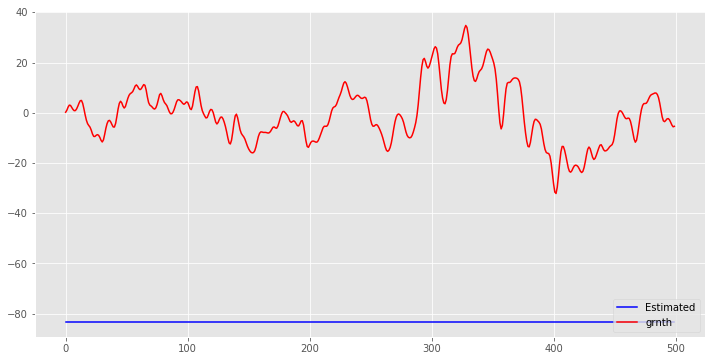

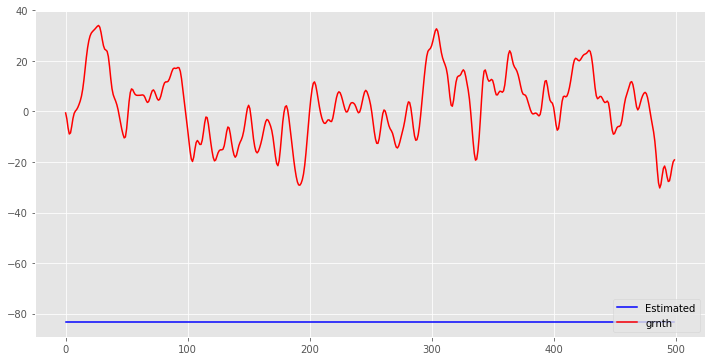

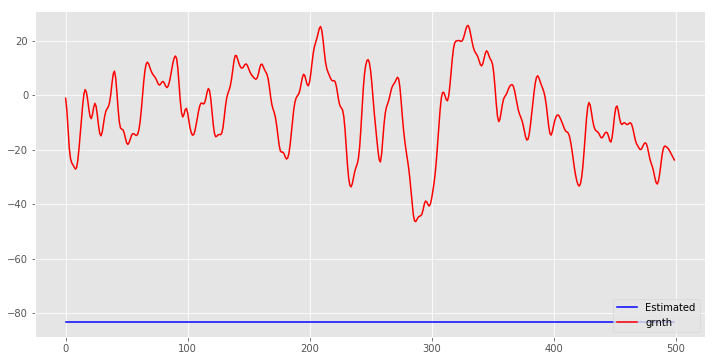

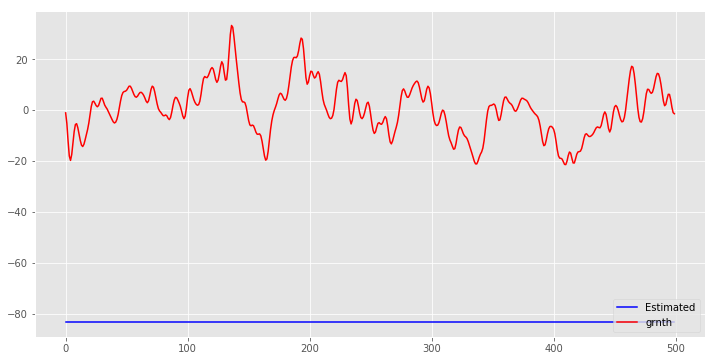

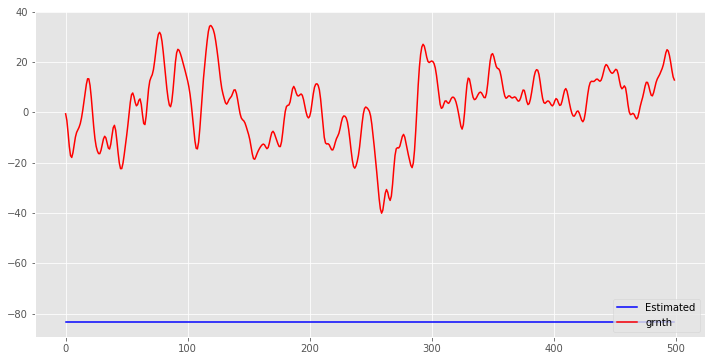

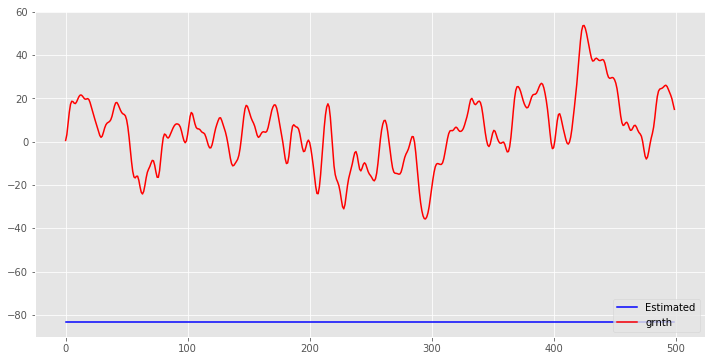

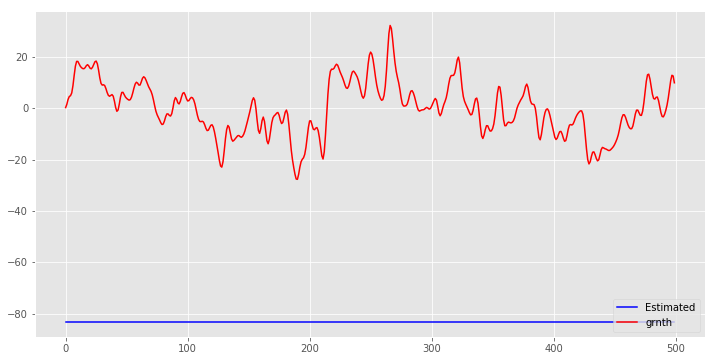

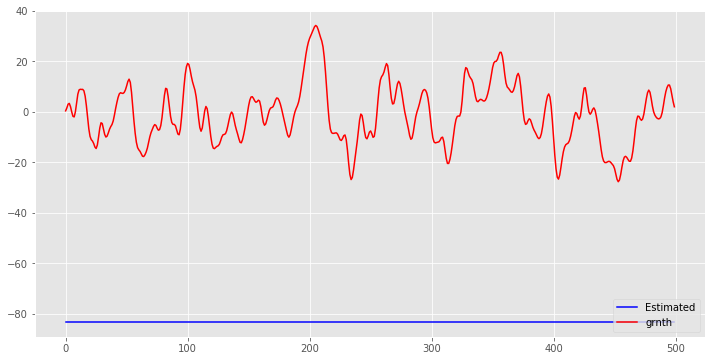

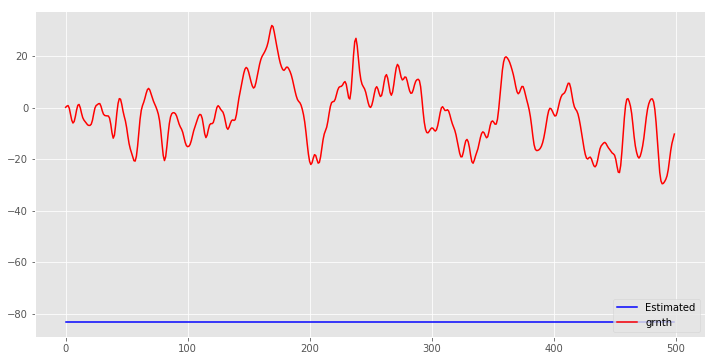

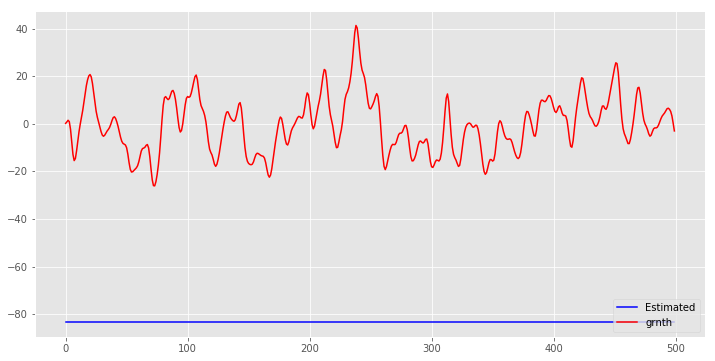

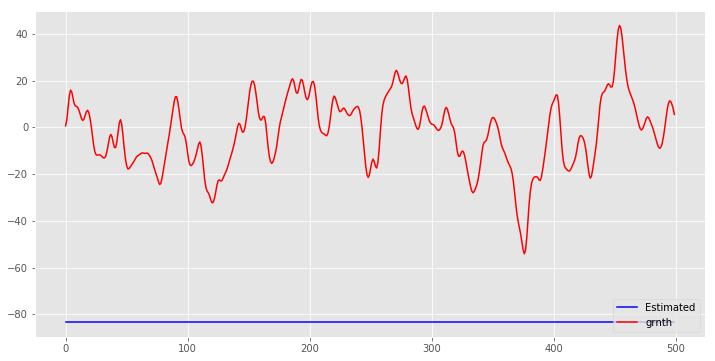

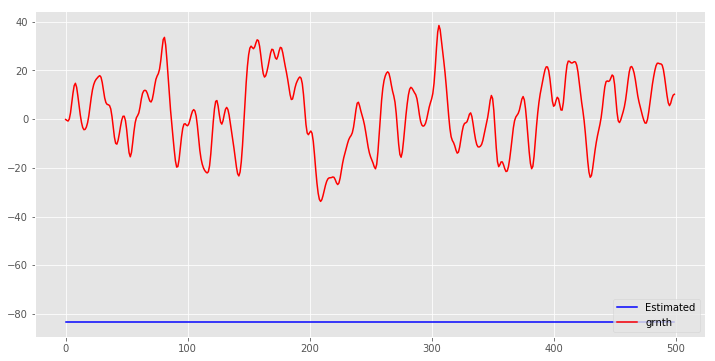

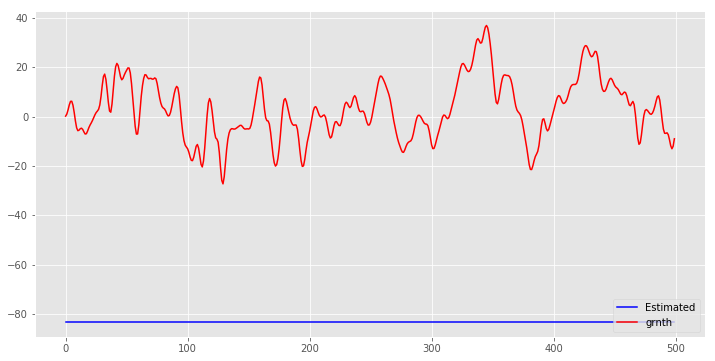

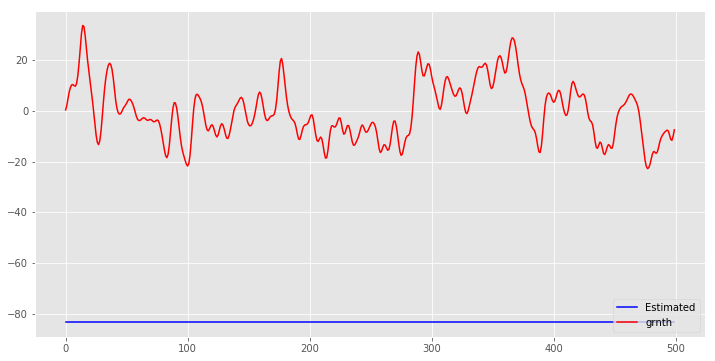

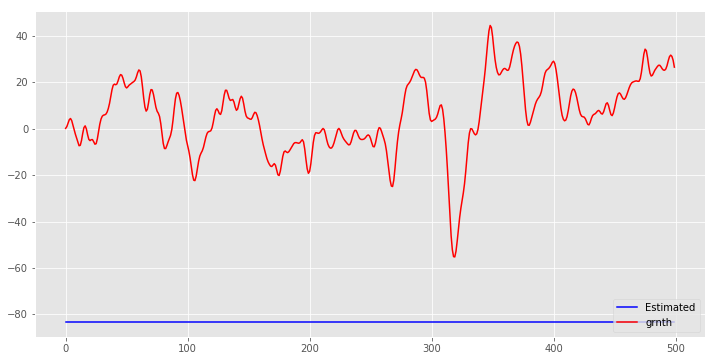

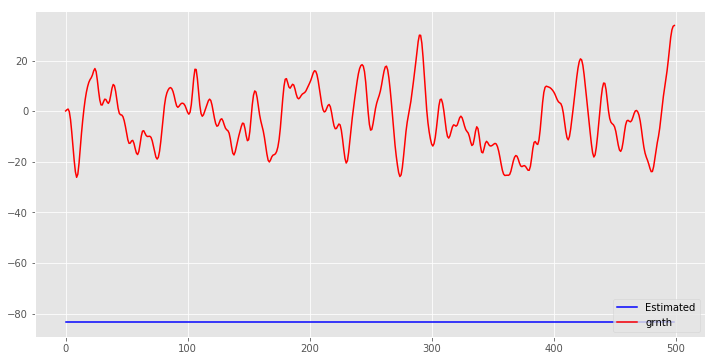

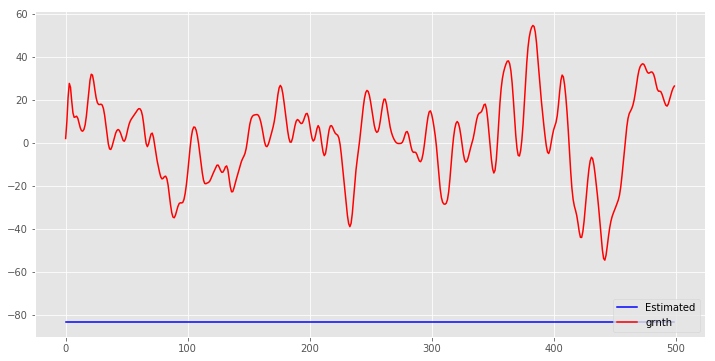

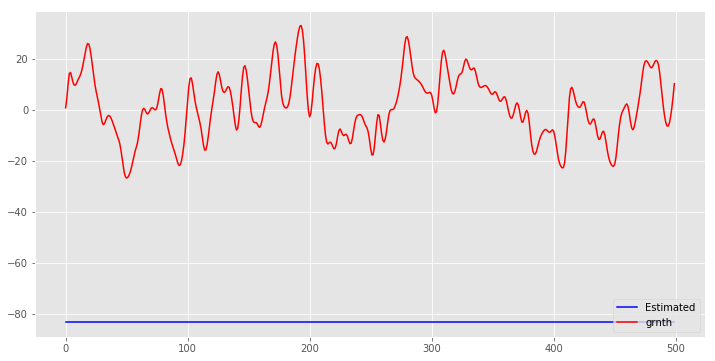

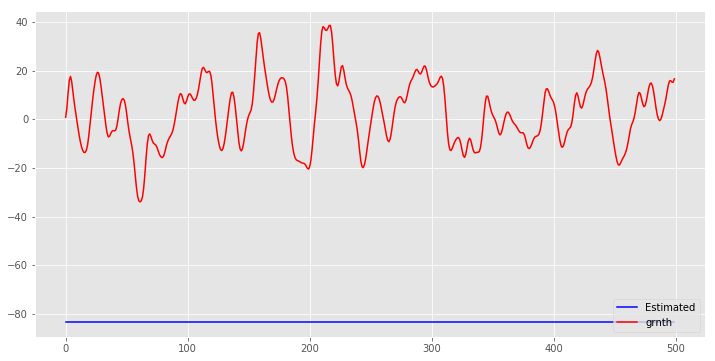

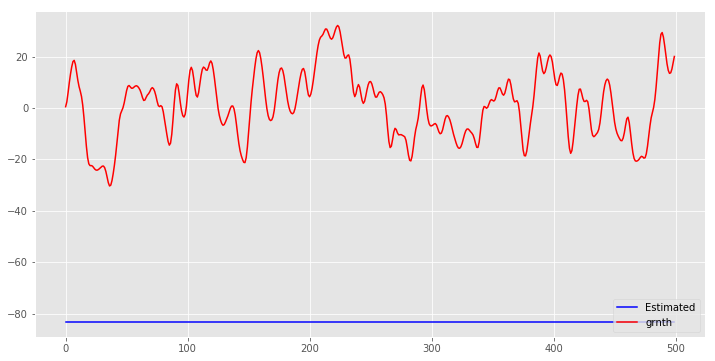

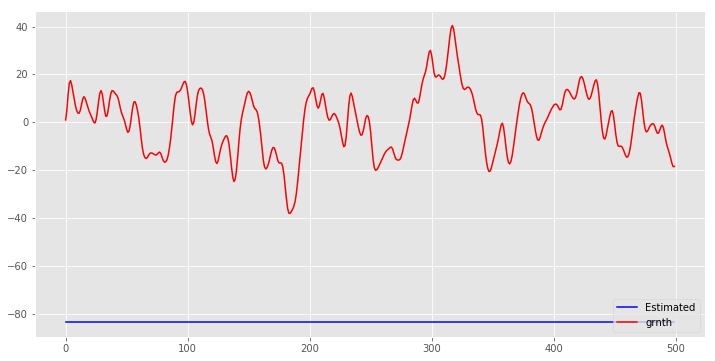

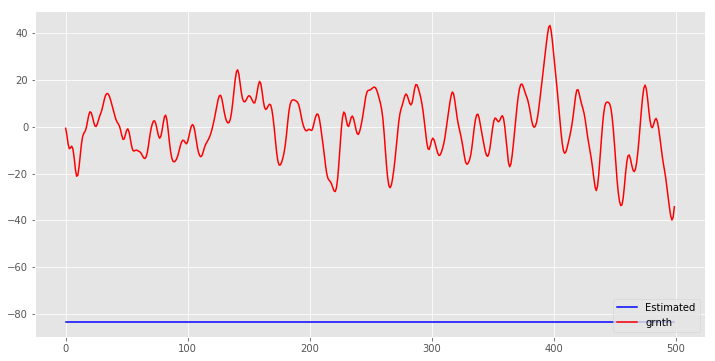

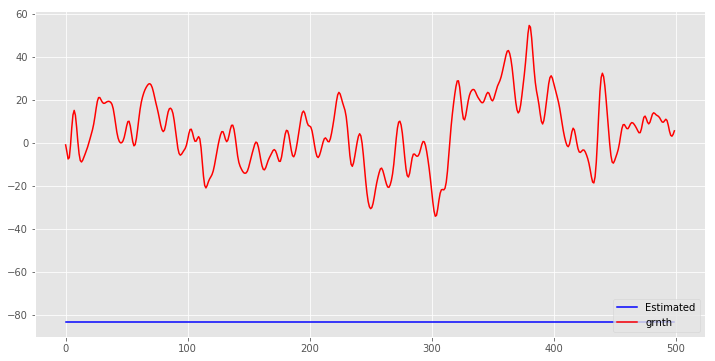

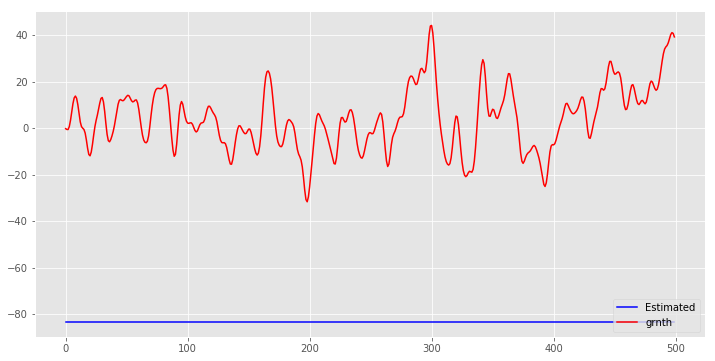

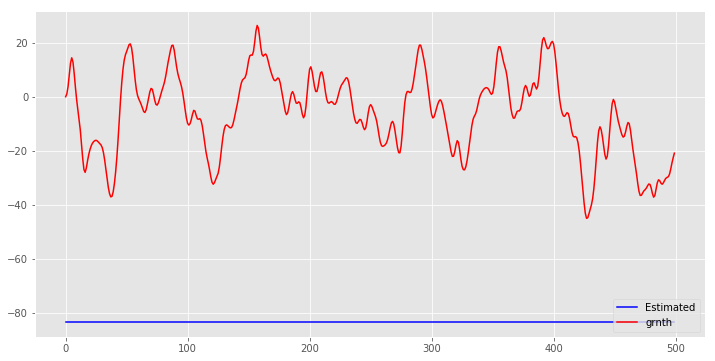

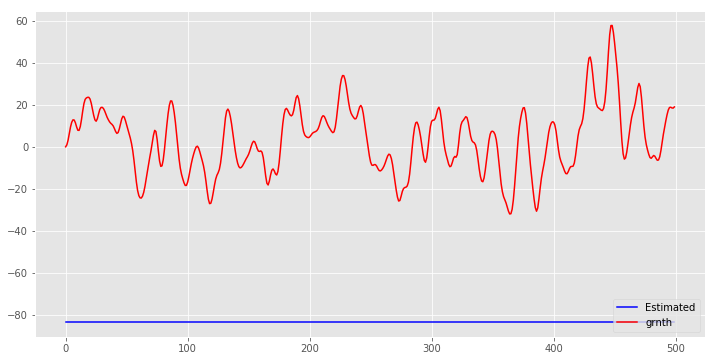

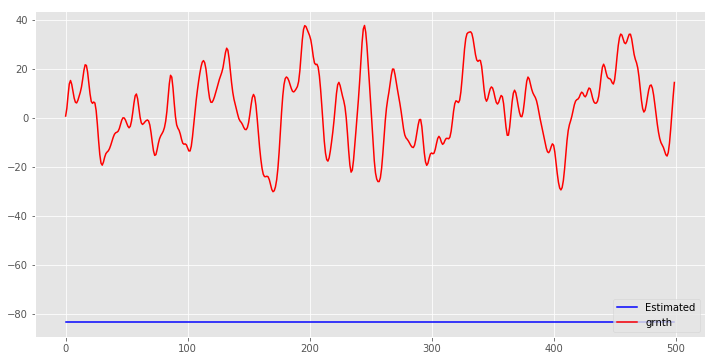

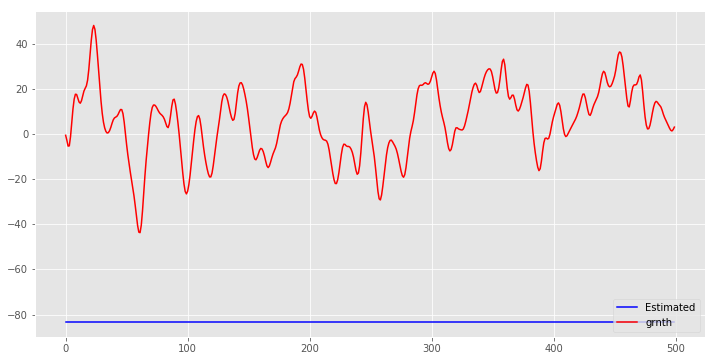

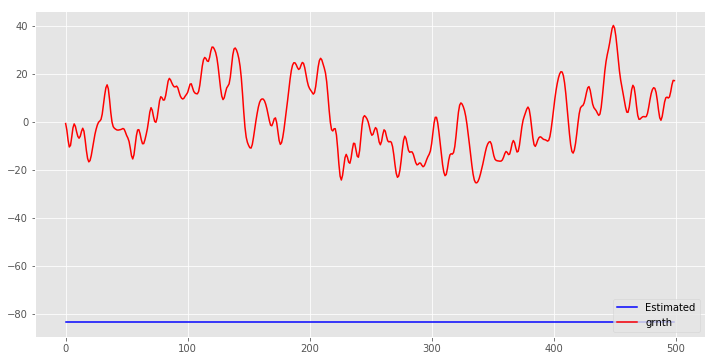

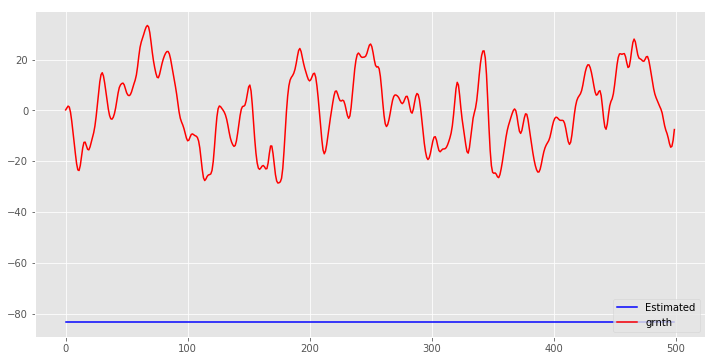

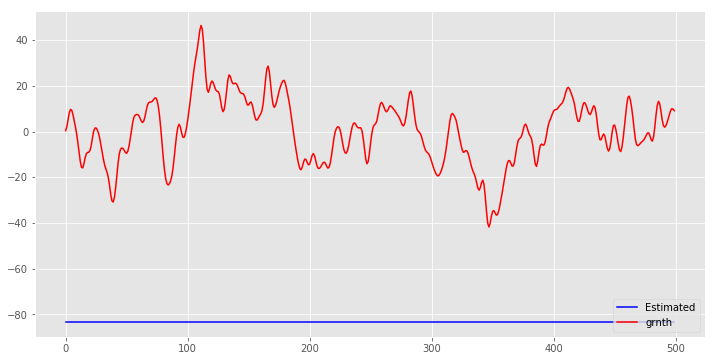

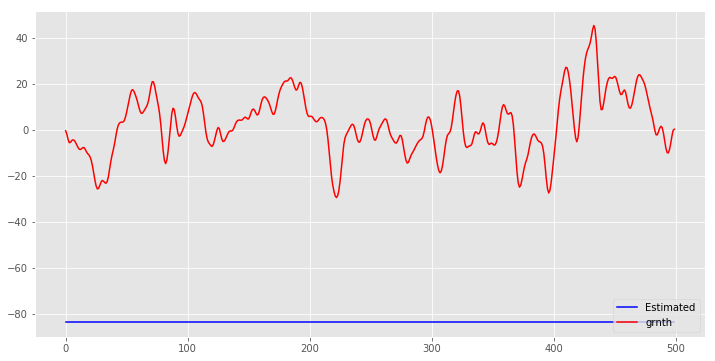

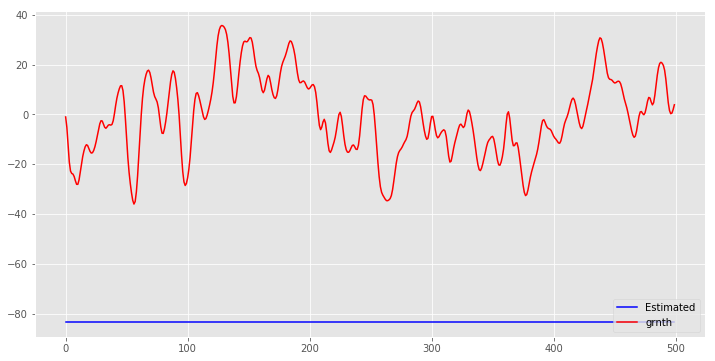

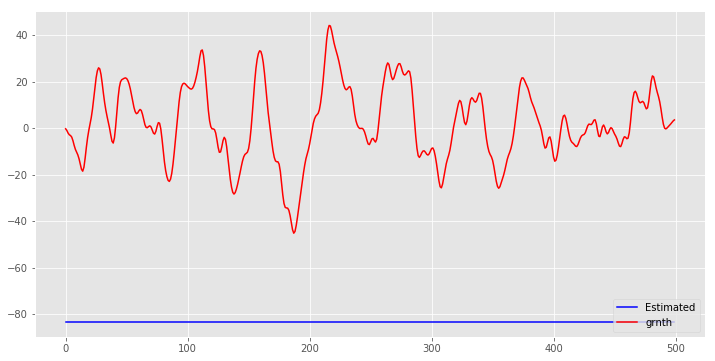

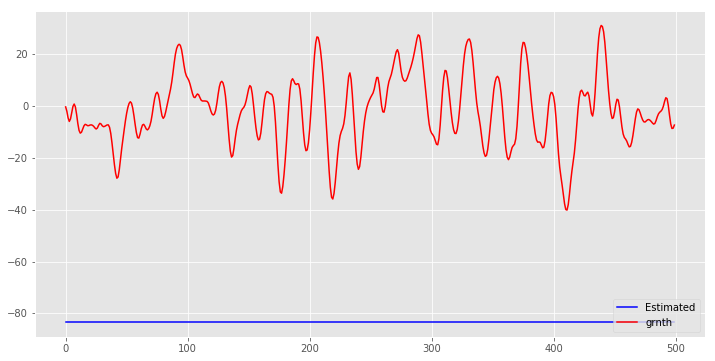

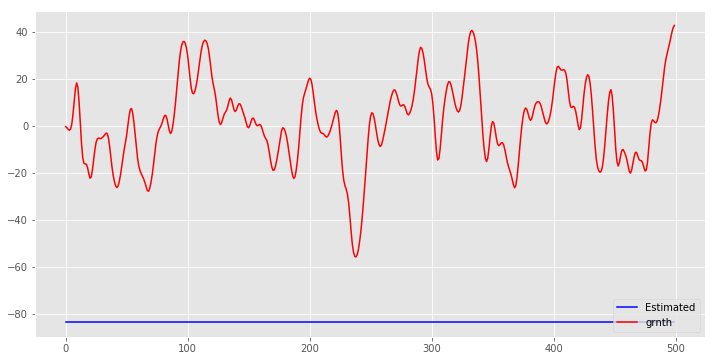

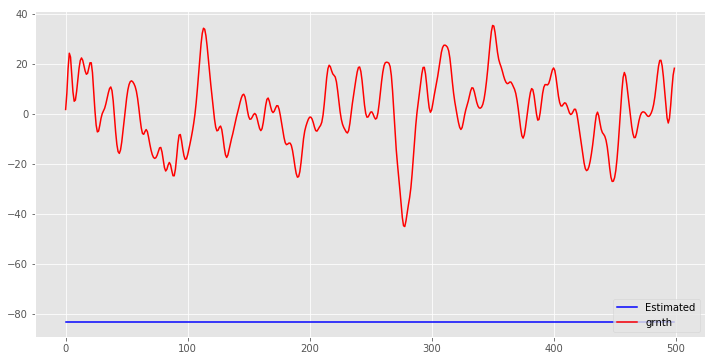

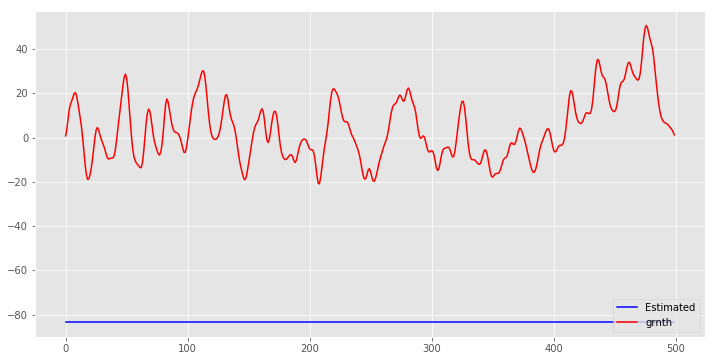

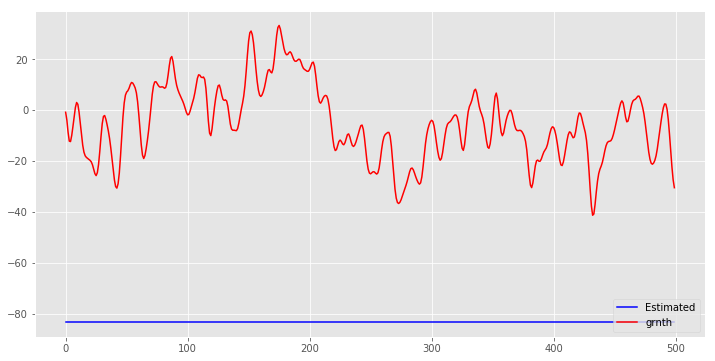

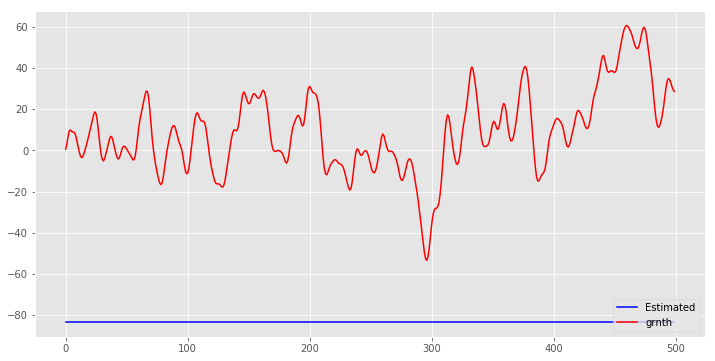

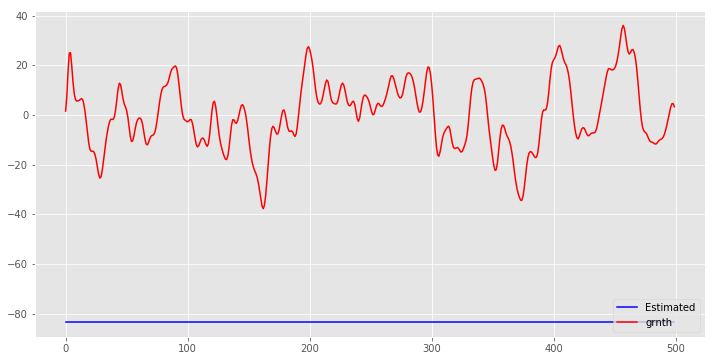

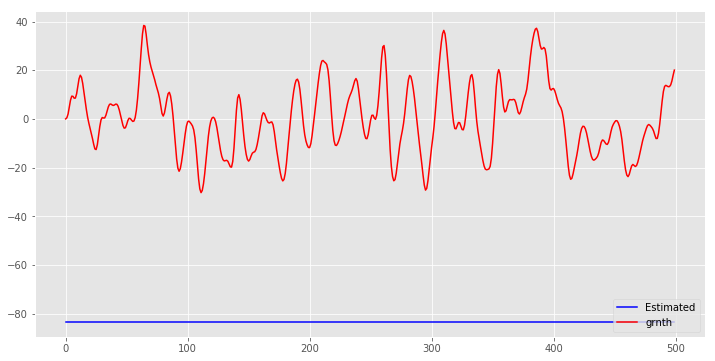

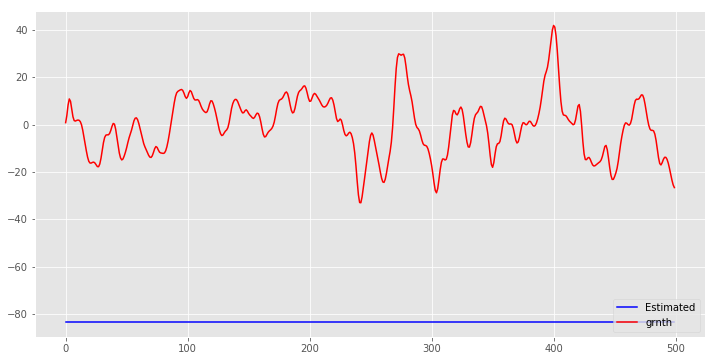

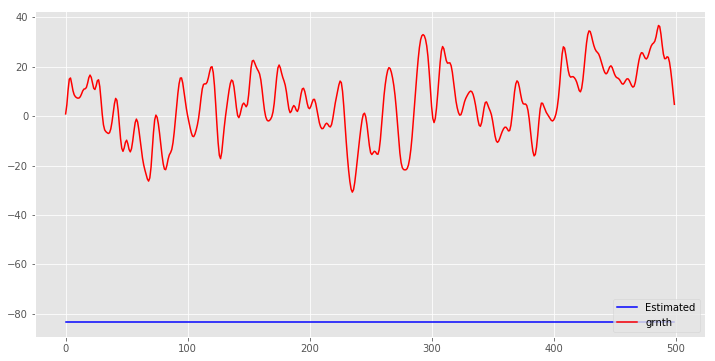

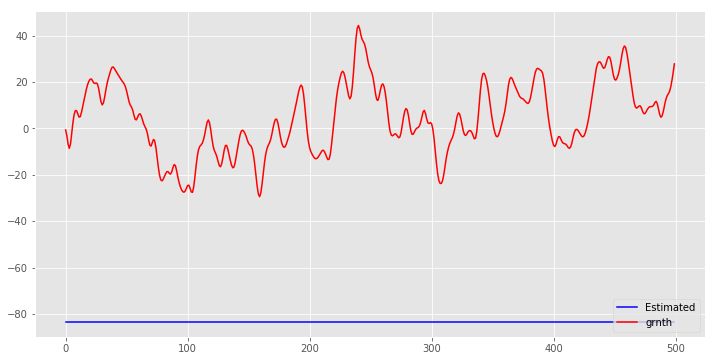

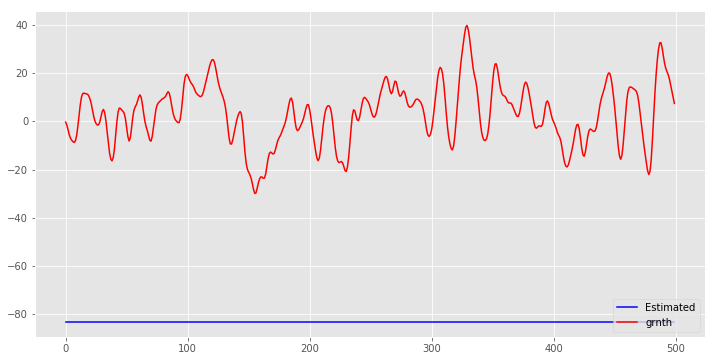

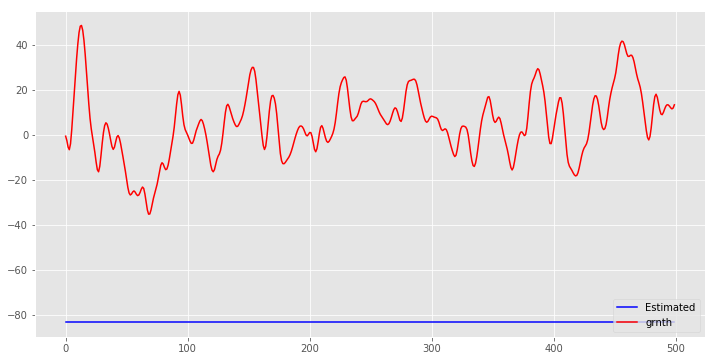

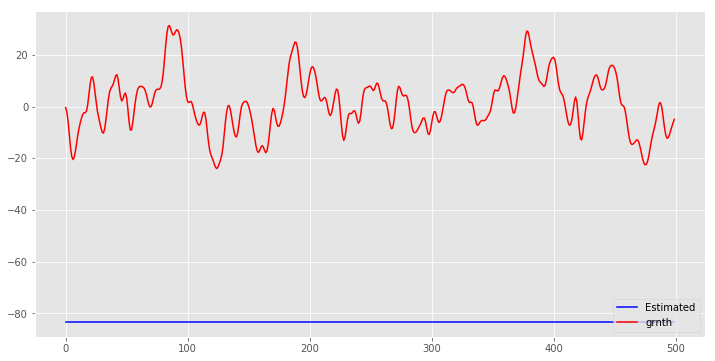

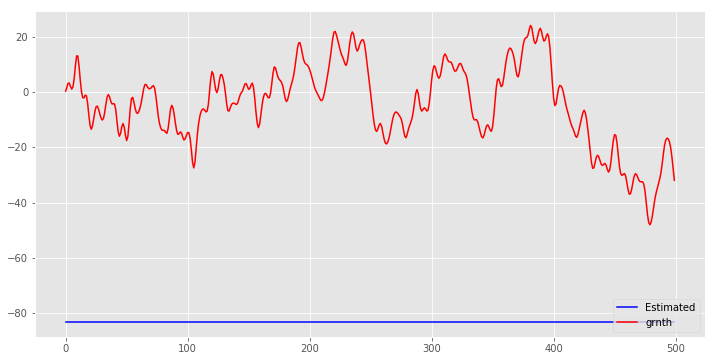

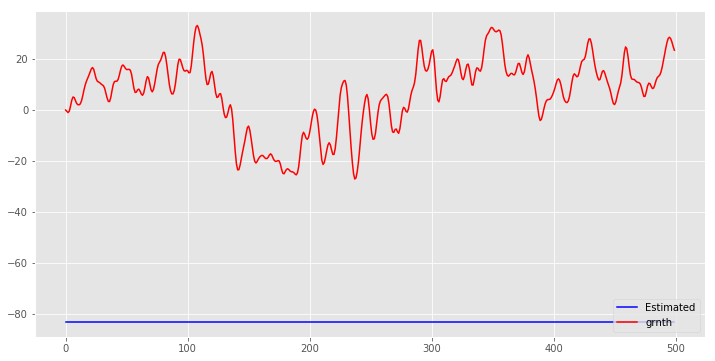

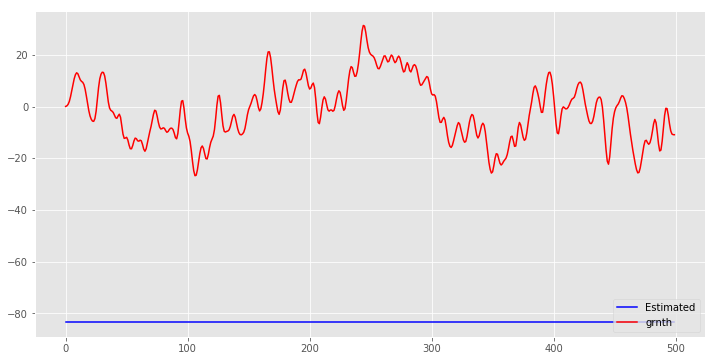

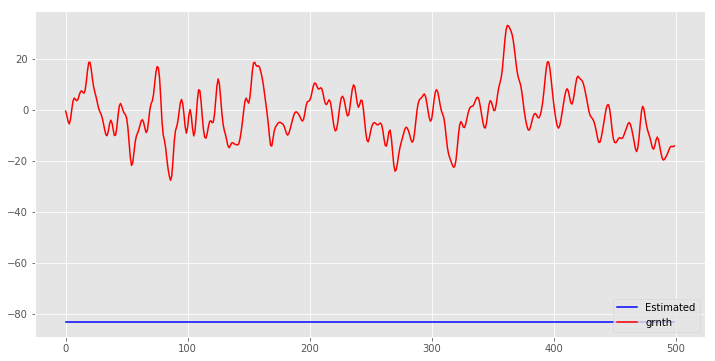

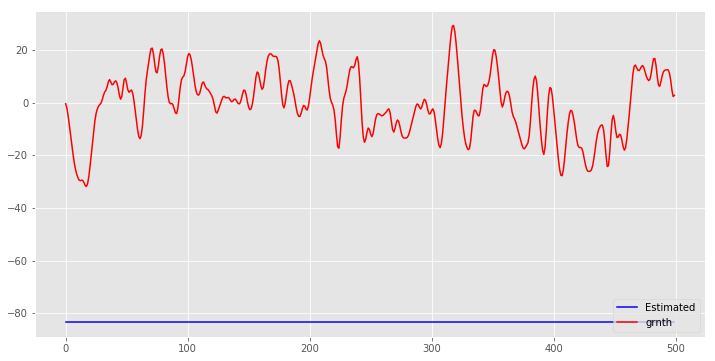

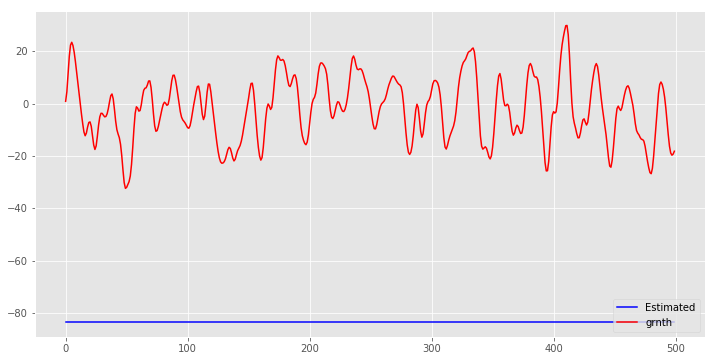

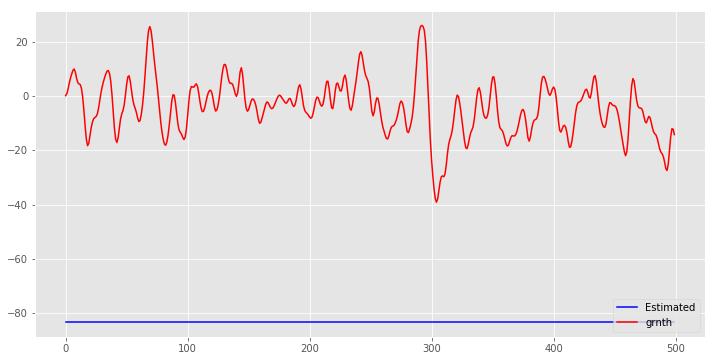

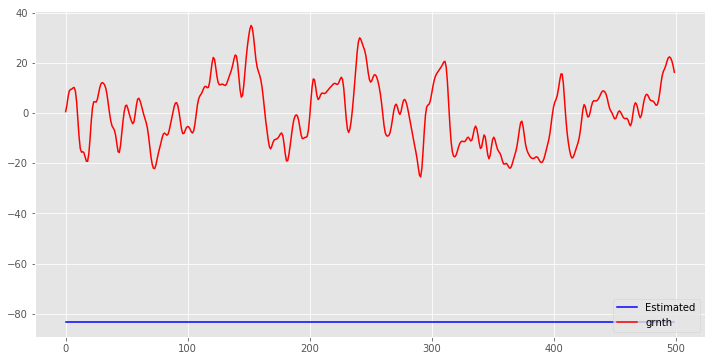

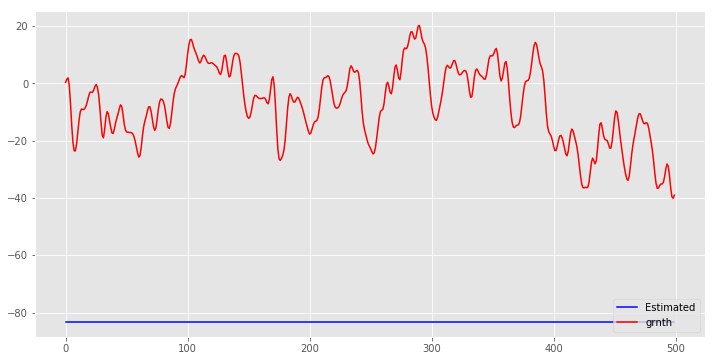

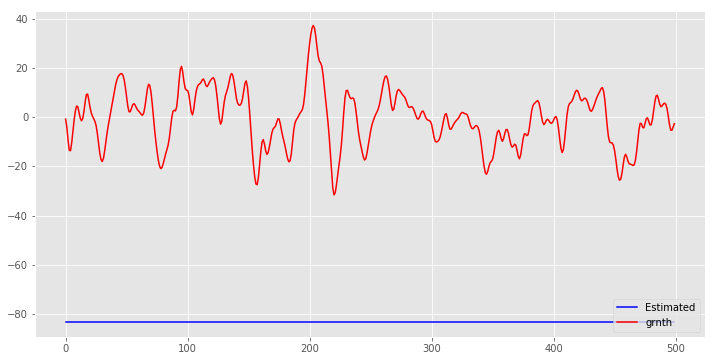

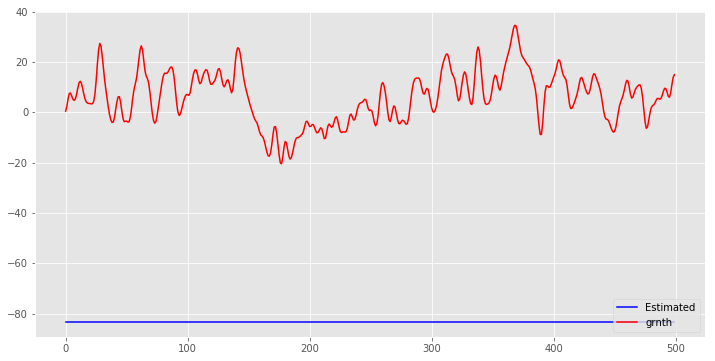

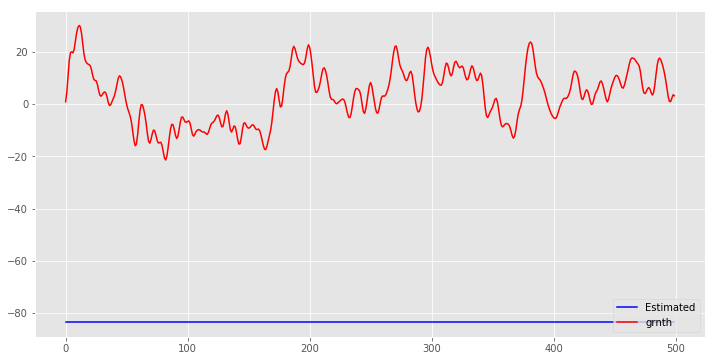

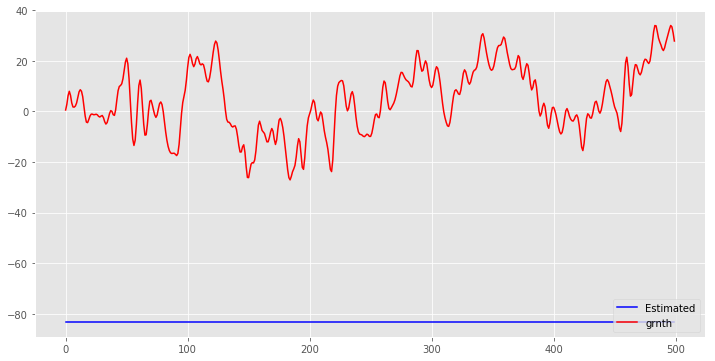

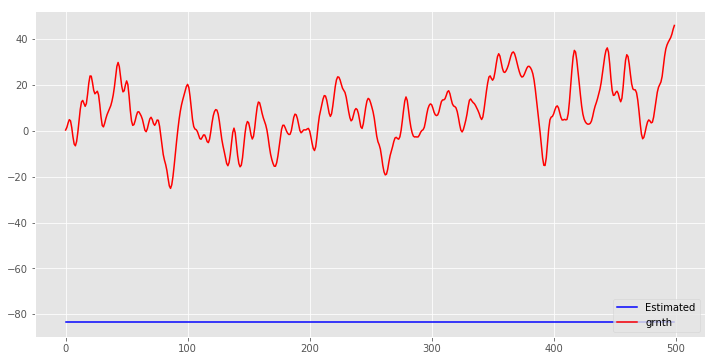

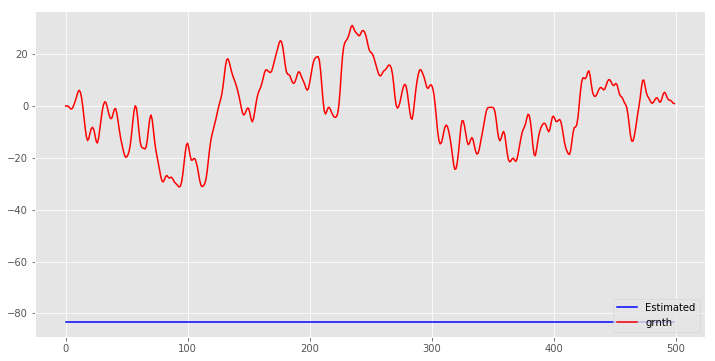

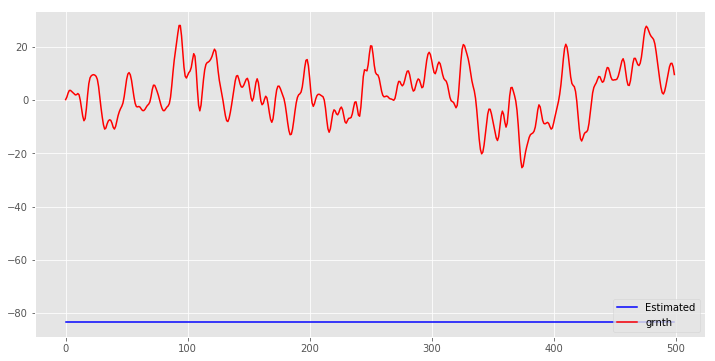

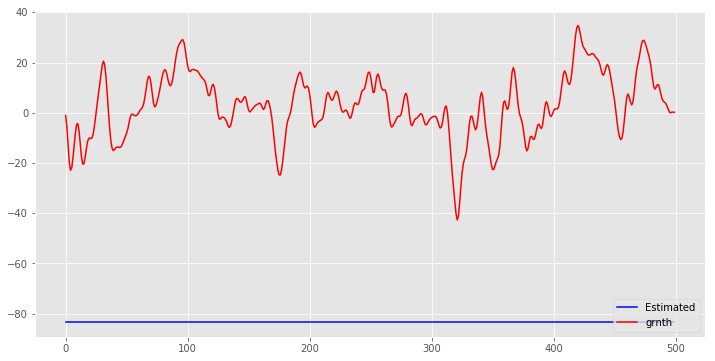

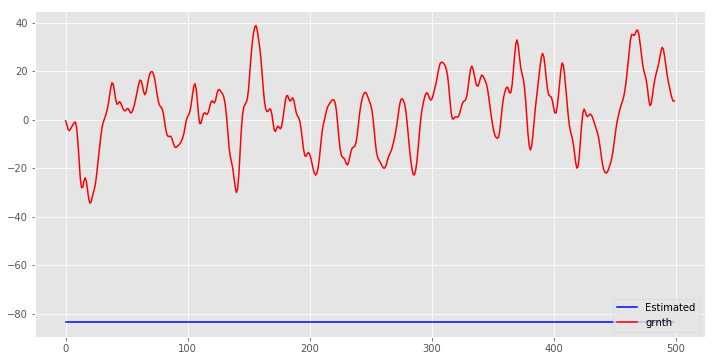

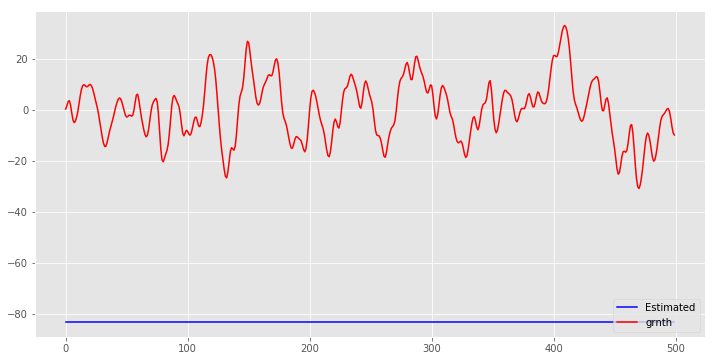

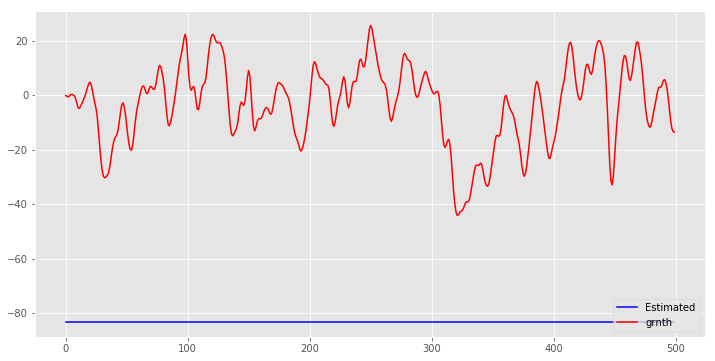

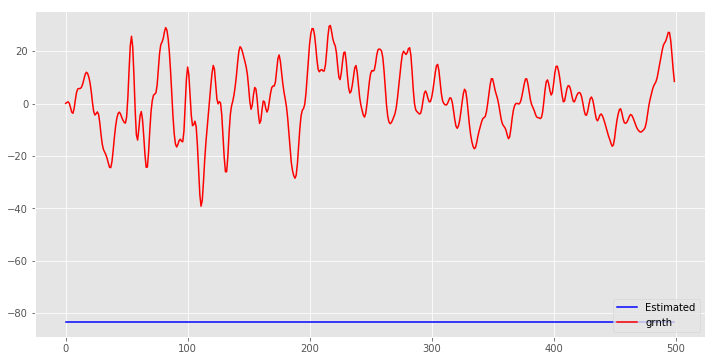

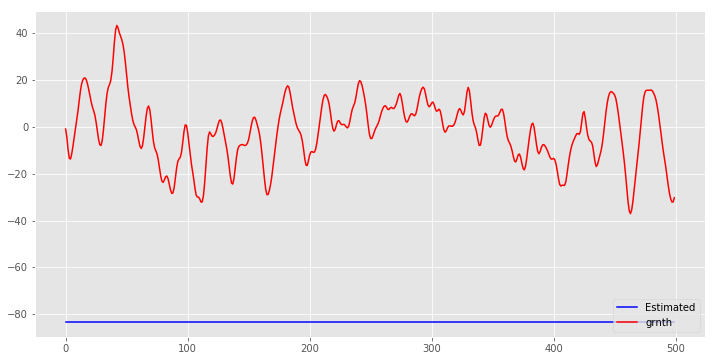

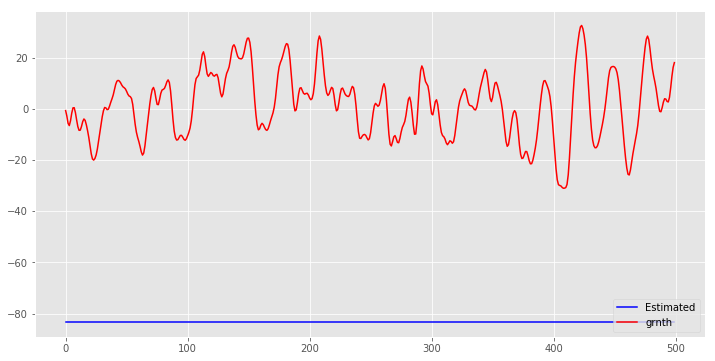

In [13]:
for i in range (y_test.shape[0]):
    
    plt.figure(num=None, figsize=(12, 6))


    plt1=plt.plot(y_predic[i],'b',label="Estimated")


    plt.plot(y_test[i],'r',label="grnth")

    plt.legend(loc=4)
#plt.title('Estimate position X with RMSE=%f'%rmsX)

#Save figure
    #plt.savefig('sig%d.png'%i,format='png')

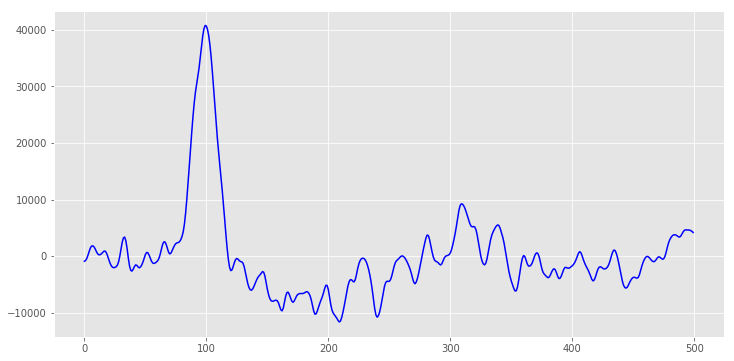

In [14]:
plt.figure(num=None, figsize=(12, 6))
#plt.plot(y_test[10],'r')
X_test=(np.multiply(x_data2,np.max(x_data2)))+-np.min(x_data)#
plt.plot(X_test[i],'b')

In [15]:
spio.savemat('y_pred3.mat', {'y_predic': y_predic})
spio.savemat('y_test3.mat', {'y_test': y_test})